In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Project Overview

### Goal:
    - The goal of this project is to develop a simple model which can use simple customer features to accurately predict client churn. 

### Business Utility: 
    - Identifying clients at high risk of churn gives us actionable intelligence in two phases.
    
        - Potential Customer Identification: By being able to quantify which charateristics make a customer likely to stay or go we can more
        tailor our marketing efforts to attract customers who are more likely to remain customers.
        
        - Utilize targeted marketing and retainment efforts at current customers who are higher risk of churn.

### Methodology: 

    - We will be using a logistic regression model which classifies customers as secure (1), or likely to churn(0).
    - There a few advantages of this model and approach:
        - It is a simple model whcih can easily be tweaked or updated for future use.
        - It is cheap to both build and maintain. 
        - It is intuitive, we input non complicated data about clients (age, gender, credit score etc.) and are able to make predictions with accuracy. 

## Exploratory Data Analysis

### Import and high-level overview

In [16]:
# Import and preview our data set
df = pd.read_csv('/Users/elias_m/Desktop/Projects - pay me/Bank Churn/Bank Customer Churn Prediction.csv')

df.head(10)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,15792365,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,15592389,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [24]:
# the following cells give us a high level overview, of the count, average and median of our dataset. 
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


### Visualizations

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


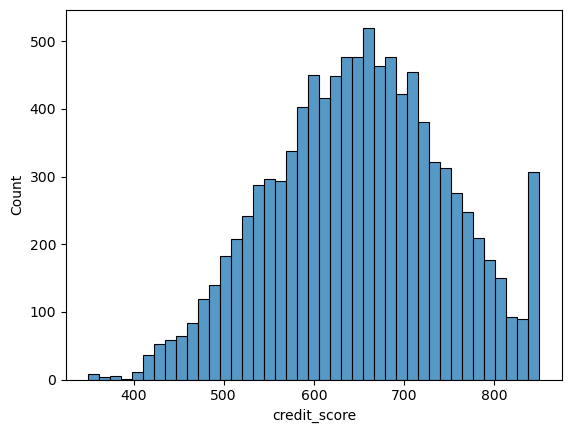

In [40]:
sns.histplot(x=df['credit_score'])
plt.show()

<Axes: xlabel='churn', ylabel='credit_score'>

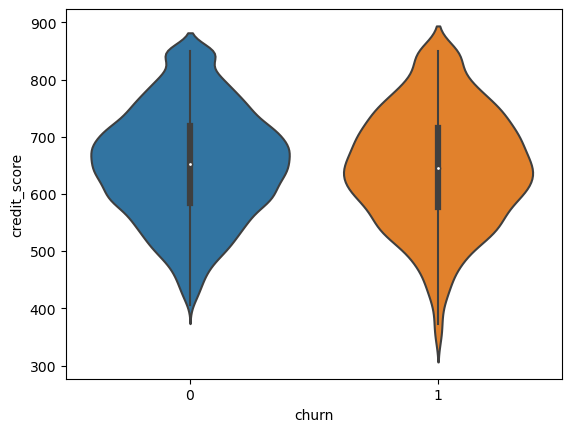

In [46]:
sns.violinplot(x='churn',y='credit_score',data = df)

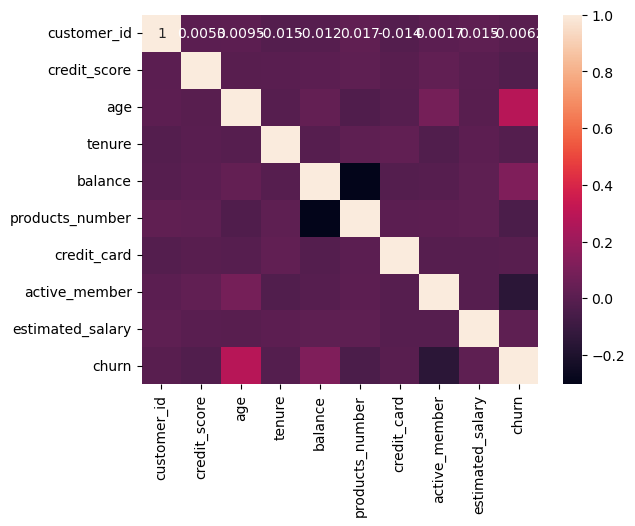

In [82]:
sns.heatmap(data=df.corr(numeric_only=True), annot=True)
plt.show()

In [98]:
df.corr(numeric_only=True)['churn'].sort_values(ascending=False)

churn               1.000000
age                 0.285323
balance             0.118533
estimated_salary    0.012097
customer_id        -0.006248
credit_card        -0.007138
tenure             -0.014001
credit_score       -0.027094
products_number    -0.047820
active_member      -0.156128
Name: churn, dtype: float64